In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import itertools
import math, calendar
import time

from torch.utils.data import DataLoader
from torch import nn
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error

sys.path.append("..")
from utils import metrics
from utils.data import TimeFusionDataset
from timefusion import TimeFusion
from utils.early_stopper import EarlyStopper

In [2]:
# Import data
train_data = pd.read_csv("../../datasets/solar/train.csv", index_col="LocalTime")
val_data = pd.read_csv("../../datasets/solar/val.csv", index_col="LocalTime")
test_data = pd.read_csv("../../datasets/solar/test.csv", index_col="LocalTime")

# Normalize the signal power of each column
stds = train_data.std()
train_data /= stds
val_data /= stds
test_data /= stds

full_data = pd.concat([train_data,val_data,test_data])

In [3]:
# Compute device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [4]:
context_length = 24*4
prediction_length = 24

def get_data_loader(data, context_length):

    dataset = TimeFusionDataset(
        data = data,
        context_length = context_length,
    )
    dataset.add_timestamp_encodings(
        timestamp_encodings = [
            lambda x: math.sin(2*math.pi*x.hour / 24),
            lambda x: math.cos(2*math.pi*x.hour / 24),
        ]
    )

    dataloader = DataLoader(
        dataset = dataset,
        shuffle = True,
        num_workers = 3,
        batch_size = 128,
    )

    return dataloader, dataset

train_loader, train_dataset = get_data_loader(train_data, context_length)
val_loader, val_dataset = get_data_loader(val_data, context_length)
test_loader, test_dataset = get_data_loader(test_data, context_length)

In [5]:
rnn_hidden = int(0.5*train_data.shape[1])
residual_hidden = int((rnn_hidden + train_data.shape[1])*2)

predictor = TimeFusion(
    input_size = train_dataset.data.shape[1],
    output_size = train_data.shape[1],
    rnn_layers = 3,
    rnn_hidden = rnn_hidden,
    residual_layers = 4,
    residual_hidden = residual_hidden,
    dropout = 0,
    scaling = False,
    device = device,
    residual_scaler = False
)

print("Number of trainable parameters:",sum(p.numel() for p in predictor.parameters()))

/rds/general/user/ejh19/home/Final-Year-Project/timefusion/examples/../utils/diffusion.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.bar_alphas = torch.tensor(


Number of trainable parameters: 884168


In [6]:
predictor.load_state_dict(torch.load("weights/solar/2023-06-11-17-14-23"))
predictor.eval()

TimeFusion(
  (epsilon_theta): EpsilonTheta(
    (embedding): DiffusionEmbedding(
      (linear1): Linear(in_features=32, out_features=68, bias=True)
      (tanh): Tanh()
      (linear2): Linear(in_features=68, out_features=68, bias=True)
    )
    (rnn): LSTM(139, 68, num_layers=3, batch_first=True)
    (residuals): Sequential(
      (0): Linear(in_features=205, out_features=205, bias=True)
      (1): ResidualBlock(
        (linear1): Linear(in_features=205, out_features=410, bias=True)
        (relu): ReLU()
        (linear2): Linear(in_features=410, out_features=205, bias=True)
        (tanh): Tanh()
      )
      (2): ResidualBlock(
        (linear1): Linear(in_features=205, out_features=410, bias=True)
        (relu): ReLU()
        (linear2): Linear(in_features=410, out_features=205, bias=True)
        (tanh): Tanh()
      )
      (3): ResidualBlock(
        (linear1): Linear(in_features=205, out_features=410, bias=True)
        (relu): ReLU()
        (linear2): Linear(in_feature

In [6]:
optimizer = torch.optim.Adam(params=predictor.parameters(), lr=1e-3, weight_decay=0)
lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.001, total_iters=200)

predictor.train_network(
    train_loader = train_loader,
    epochs=200,
    val_loader = val_loader,
    optimizer = optimizer,
    lr_scheduler= lr_scheduler,
    early_stopper=EarlyStopper(patience=200),
    disable_progress_bar = False,
    save_weights = True,
    weight_folder = "weights/solar"
)

Epoch: 1/200: 100%|██████████| 54/54 [00:01<00:00, 38.83batch/s, Training loss=0.7538]


val_loss: 0.5710 , 


Epoch: 2/200: 100%|██████████| 54/54 [00:01<00:00, 41.63batch/s, Training loss=0.4852]


val_loss: 0.4069 , 


Epoch: 3/200: 100%|██████████| 54/54 [00:01<00:00, 43.99batch/s, Training loss=0.3735]


val_loss: 0.3262 , 


Epoch: 4/200: 100%|██████████| 54/54 [00:01<00:00, 43.91batch/s, Training loss=0.3150]


val_loss: 0.2708 , 


Epoch: 5/200: 100%|██████████| 54/54 [00:01<00:00, 43.12batch/s, Training loss=0.2704]


val_loss: 0.2500 , 


Epoch: 6/200: 100%|██████████| 54/54 [00:01<00:00, 40.96batch/s, Training loss=0.2466]


val_loss: 0.2192 , 


Epoch: 7/200: 100%|██████████| 54/54 [00:01<00:00, 41.78batch/s, Training loss=0.2220]


val_loss: 0.2081 , 


Epoch: 8/200: 100%|██████████| 54/54 [00:01<00:00, 41.71batch/s, Training loss=0.2077]


val_loss: 0.1847 , 


Epoch: 9/200: 100%|██████████| 54/54 [00:01<00:00, 42.07batch/s, Training loss=0.1965]


val_loss: 0.1955 , 


Epoch: 10/200: 100%|██████████| 54/54 [00:01<00:00, 42.37batch/s, Training loss=0.1822]


val_loss: 0.1618 , 


Epoch: 11/200: 100%|██████████| 54/54 [00:01<00:00, 42.55batch/s, Training loss=0.1725]


val_loss: 0.1687 , 


Epoch: 12/200: 100%|██████████| 54/54 [00:01<00:00, 42.87batch/s, Training loss=0.1639]


val_loss: 0.1462 , 


Epoch: 13/200: 100%|██████████| 54/54 [00:01<00:00, 42.85batch/s, Training loss=0.1577]


val_loss: 0.1452 , 


Epoch: 14/200: 100%|██████████| 54/54 [00:01<00:00, 41.30batch/s, Training loss=0.1542]


val_loss: 0.1591 , 


Epoch: 15/200: 100%|██████████| 54/54 [00:01<00:00, 42.09batch/s, Training loss=0.1474]


val_loss: 0.1337 , 


Epoch: 16/200: 100%|██████████| 54/54 [00:01<00:00, 41.86batch/s, Training loss=0.1466]


val_loss: 0.1358 , 


Epoch: 17/200: 100%|██████████| 54/54 [00:01<00:00, 42.13batch/s, Training loss=0.1418]


val_loss: 0.1308 , 


Epoch: 18/200: 100%|██████████| 54/54 [00:01<00:00, 42.39batch/s, Training loss=0.1405]


val_loss: 0.1258 , 


Epoch: 19/200: 100%|██████████| 54/54 [00:01<00:00, 41.37batch/s, Training loss=0.1358]


val_loss: 0.1204 , 


Epoch: 20/200: 100%|██████████| 54/54 [00:01<00:00, 41.30batch/s, Training loss=0.1330]


val_loss: 0.1089 , 


Epoch: 21/200: 100%|██████████| 54/54 [00:01<00:00, 41.92batch/s, Training loss=0.1322]


val_loss: 0.1283 , 


Epoch: 22/200: 100%|██████████| 54/54 [00:01<00:00, 41.43batch/s, Training loss=0.1281]


val_loss: 0.1092 , 


Epoch: 23/200: 100%|██████████| 54/54 [00:01<00:00, 41.19batch/s, Training loss=0.1288]


val_loss: 0.1179 , 


Epoch: 24/200: 100%|██████████| 54/54 [00:01<00:00, 40.94batch/s, Training loss=0.1284]


val_loss: 0.1186 , 


Epoch: 25/200: 100%|██████████| 54/54 [00:01<00:00, 41.78batch/s, Training loss=0.1225]


val_loss: 0.1088 , 


Epoch: 26/200: 100%|██████████| 54/54 [00:01<00:00, 41.66batch/s, Training loss=0.1245]


val_loss: 0.1250 , 


Epoch: 27/200: 100%|██████████| 54/54 [00:01<00:00, 41.33batch/s, Training loss=0.1220]


val_loss: 0.1141 , 


Epoch: 28/200: 100%|██████████| 54/54 [00:01<00:00, 41.57batch/s, Training loss=0.1189]


val_loss: 0.1138 , 


Epoch: 29/200: 100%|██████████| 54/54 [00:01<00:00, 41.40batch/s, Training loss=0.1217]


val_loss: 0.1333 , 


Epoch: 30/200: 100%|██████████| 54/54 [00:01<00:00, 42.21batch/s, Training loss=0.1162]


val_loss: 0.0949 , 


Epoch: 31/200: 100%|██████████| 54/54 [00:01<00:00, 41.29batch/s, Training loss=0.1140]


val_loss: 0.0972 , 


Epoch: 32/200: 100%|██████████| 54/54 [00:01<00:00, 41.47batch/s, Training loss=0.1150]


val_loss: 0.1077 , 


Epoch: 33/200: 100%|██████████| 54/54 [00:01<00:00, 42.18batch/s, Training loss=0.1198]


val_loss: 0.1110 , 


Epoch: 34/200: 100%|██████████| 54/54 [00:01<00:00, 41.33batch/s, Training loss=0.1176]


val_loss: 0.1167 , 


Epoch: 35/200: 100%|██████████| 54/54 [00:01<00:00, 42.08batch/s, Training loss=0.1136]


val_loss: 0.1214 , 


Epoch: 36/200: 100%|██████████| 54/54 [00:01<00:00, 42.07batch/s, Training loss=0.1147]


val_loss: 0.0910 , 


Epoch: 37/200: 100%|██████████| 54/54 [00:01<00:00, 42.21batch/s, Training loss=0.1142]


val_loss: 0.0999 , 


Epoch: 38/200: 100%|██████████| 54/54 [00:01<00:00, 40.38batch/s, Training loss=0.1145]


val_loss: 0.1137 , 


Epoch: 39/200: 100%|██████████| 54/54 [00:01<00:00, 41.99batch/s, Training loss=0.1133]


val_loss: 0.0848 , 


Epoch: 40/200: 100%|██████████| 54/54 [00:01<00:00, 42.10batch/s, Training loss=0.1096]


val_loss: 0.1216 , 


Epoch: 41/200: 100%|██████████| 54/54 [00:01<00:00, 40.81batch/s, Training loss=0.1067]


val_loss: 0.1009 , 


Epoch: 42/200: 100%|██████████| 54/54 [00:01<00:00, 41.44batch/s, Training loss=0.1118]


val_loss: 0.0965 , 


Epoch: 43/200: 100%|██████████| 54/54 [00:01<00:00, 41.79batch/s, Training loss=0.1117]


val_loss: 0.1101 , 


Epoch: 44/200: 100%|██████████| 54/54 [00:01<00:00, 40.36batch/s, Training loss=0.1074]


val_loss: 0.0976 , 


Epoch: 45/200: 100%|██████████| 54/54 [00:01<00:00, 40.83batch/s, Training loss=0.1064]


val_loss: 0.1102 , 


Epoch: 46/200: 100%|██████████| 54/54 [00:01<00:00, 40.86batch/s, Training loss=0.1062]


val_loss: 0.0988 , 


Epoch: 47/200: 100%|██████████| 54/54 [00:01<00:00, 38.91batch/s, Training loss=0.1036]


val_loss: 0.0915 , 


Epoch: 48/200: 100%|██████████| 54/54 [00:01<00:00, 41.10batch/s, Training loss=0.1045]


val_loss: 0.0972 , 


Epoch: 49/200: 100%|██████████| 54/54 [00:01<00:00, 40.28batch/s, Training loss=0.1035]


val_loss: 0.1015 , 


Epoch: 50/200: 100%|██████████| 54/54 [00:01<00:00, 41.45batch/s, Training loss=0.1006]


val_loss: 0.0884 , 


Epoch: 51/200: 100%|██████████| 54/54 [00:01<00:00, 41.84batch/s, Training loss=0.1026]


val_loss: 0.0875 , 


Epoch: 52/200: 100%|██████████| 54/54 [00:01<00:00, 41.24batch/s, Training loss=0.1017]


val_loss: 0.1120 , 


Epoch: 53/200: 100%|██████████| 54/54 [00:01<00:00, 42.08batch/s, Training loss=0.1084]


val_loss: 0.1021 , 


Epoch: 54/200: 100%|██████████| 54/54 [00:01<00:00, 40.76batch/s, Training loss=0.1017]


val_loss: 0.0829 , 


Epoch: 55/200: 100%|██████████| 54/54 [00:01<00:00, 41.59batch/s, Training loss=0.0991]


val_loss: 0.0876 , 


Epoch: 56/200: 100%|██████████| 54/54 [00:01<00:00, 41.94batch/s, Training loss=0.0987]


val_loss: 0.0842 , 


Epoch: 57/200: 100%|██████████| 54/54 [00:01<00:00, 42.37batch/s, Training loss=0.0998]


val_loss: 0.0986 , 


Epoch: 58/200: 100%|██████████| 54/54 [00:01<00:00, 41.73batch/s, Training loss=0.1040]


val_loss: 0.0837 , 


Epoch: 59/200: 100%|██████████| 54/54 [00:01<00:00, 42.40batch/s, Training loss=0.1012]


val_loss: 0.0842 , 


Epoch: 60/200: 100%|██████████| 54/54 [00:01<00:00, 42.21batch/s, Training loss=0.1012]


val_loss: 0.0876 , 


Epoch: 61/200: 100%|██████████| 54/54 [00:01<00:00, 41.22batch/s, Training loss=0.0959]


val_loss: 0.0862 , 


Epoch: 62/200: 100%|██████████| 54/54 [00:01<00:00, 41.41batch/s, Training loss=0.0989]


val_loss: 0.1087 , 


Epoch: 63/200: 100%|██████████| 54/54 [00:01<00:00, 41.54batch/s, Training loss=0.0967]


val_loss: 0.0841 , 


Epoch: 64/200: 100%|██████████| 54/54 [00:01<00:00, 41.28batch/s, Training loss=0.0968]


val_loss: 0.0982 , 


Epoch: 65/200: 100%|██████████| 54/54 [00:01<00:00, 41.84batch/s, Training loss=0.0929]


val_loss: 0.0746 , 


Epoch: 66/200: 100%|██████████| 54/54 [00:01<00:00, 42.21batch/s, Training loss=0.0981]


val_loss: 0.1017 , 


Epoch: 67/200: 100%|██████████| 54/54 [00:01<00:00, 41.59batch/s, Training loss=0.0935]


val_loss: 0.0945 , 


Epoch: 68/200: 100%|██████████| 54/54 [00:01<00:00, 41.87batch/s, Training loss=0.0955]


val_loss: 0.0792 , 


Epoch: 69/200: 100%|██████████| 54/54 [00:01<00:00, 42.53batch/s, Training loss=0.0969]


val_loss: 0.0839 , 


Epoch: 70/200: 100%|██████████| 54/54 [00:01<00:00, 41.55batch/s, Training loss=0.0936]


val_loss: 0.0759 , 


Epoch: 71/200: 100%|██████████| 54/54 [00:01<00:00, 41.62batch/s, Training loss=0.0930]


val_loss: 0.0803 , 


Epoch: 72/200: 100%|██████████| 54/54 [00:01<00:00, 41.76batch/s, Training loss=0.0977]


val_loss: 0.0830 , 


Epoch: 73/200: 100%|██████████| 54/54 [00:01<00:00, 41.83batch/s, Training loss=0.0950]


val_loss: 0.0926 , 


Epoch: 74/200: 100%|██████████| 54/54 [00:01<00:00, 41.43batch/s, Training loss=0.0985]


val_loss: 0.0799 , 


Epoch: 75/200: 100%|██████████| 54/54 [00:01<00:00, 41.63batch/s, Training loss=0.0964]


val_loss: 0.0918 , 


Epoch: 76/200: 100%|██████████| 54/54 [00:01<00:00, 41.78batch/s, Training loss=0.0934]


val_loss: 0.0753 , 


Epoch: 77/200: 100%|██████████| 54/54 [00:01<00:00, 41.86batch/s, Training loss=0.0925]


val_loss: 0.0730 , 


Epoch: 78/200: 100%|██████████| 54/54 [00:01<00:00, 40.09batch/s, Training loss=0.0937]


val_loss: 0.0833 , 


Epoch: 79/200: 100%|██████████| 54/54 [00:01<00:00, 37.20batch/s, Training loss=0.0951]


val_loss: 0.0987 , 


Epoch: 80/200: 100%|██████████| 54/54 [00:01<00:00, 42.11batch/s, Training loss=0.0918]


val_loss: 0.0780 , 


Epoch: 81/200: 100%|██████████| 54/54 [00:01<00:00, 41.93batch/s, Training loss=0.0883]


val_loss: 0.0805 , 


Epoch: 82/200: 100%|██████████| 54/54 [00:01<00:00, 41.81batch/s, Training loss=0.0911]


val_loss: 0.0771 , 


Epoch: 83/200: 100%|██████████| 54/54 [00:01<00:00, 41.92batch/s, Training loss=0.0942]


val_loss: 0.0854 , 


Epoch: 84/200: 100%|██████████| 54/54 [00:01<00:00, 41.84batch/s, Training loss=0.0925]


val_loss: 0.0770 , 


Epoch: 85/200: 100%|██████████| 54/54 [00:01<00:00, 41.70batch/s, Training loss=0.0919]


val_loss: 0.0723 , 


Epoch: 86/200: 100%|██████████| 54/54 [00:01<00:00, 41.59batch/s, Training loss=0.0902]


val_loss: 0.0863 , 


Epoch: 87/200: 100%|██████████| 54/54 [00:01<00:00, 41.31batch/s, Training loss=0.0908]


val_loss: 0.0860 , 


Epoch: 88/200: 100%|██████████| 54/54 [00:01<00:00, 41.67batch/s, Training loss=0.0900]


val_loss: 0.0916 , 


Epoch: 89/200: 100%|██████████| 54/54 [00:01<00:00, 41.90batch/s, Training loss=0.0872]


val_loss: 0.0802 , 


Epoch: 90/200: 100%|██████████| 54/54 [00:01<00:00, 40.36batch/s, Training loss=0.0883]


val_loss: 0.0721 , 


Epoch: 91/200: 100%|██████████| 54/54 [00:01<00:00, 40.51batch/s, Training loss=0.0915]


val_loss: 0.0793 , 


Epoch: 92/200: 100%|██████████| 54/54 [00:01<00:00, 40.05batch/s, Training loss=0.0879]


val_loss: 0.0697 , 


Epoch: 93/200: 100%|██████████| 54/54 [00:01<00:00, 41.42batch/s, Training loss=0.0863]


val_loss: 0.0839 , 


Epoch: 94/200: 100%|██████████| 54/54 [00:01<00:00, 40.85batch/s, Training loss=0.0920]


val_loss: 0.0807 , 


Epoch: 95/200: 100%|██████████| 54/54 [00:01<00:00, 41.98batch/s, Training loss=0.0873]


val_loss: 0.0721 , 


Epoch: 96/200: 100%|██████████| 54/54 [00:01<00:00, 41.81batch/s, Training loss=0.0877]


val_loss: 0.0930 , 


Epoch: 97/200: 100%|██████████| 54/54 [00:01<00:00, 42.14batch/s, Training loss=0.0856]


val_loss: 0.0906 , 


Epoch: 98/200: 100%|██████████| 54/54 [00:01<00:00, 41.68batch/s, Training loss=0.0859]


val_loss: 0.0780 , 


Epoch: 99/200: 100%|██████████| 54/54 [00:01<00:00, 41.13batch/s, Training loss=0.0878]


val_loss: 0.0842 , 


Epoch: 100/200: 100%|██████████| 54/54 [00:01<00:00, 43.02batch/s, Training loss=0.0811]


val_loss: 0.0731 , 


Epoch: 101/200: 100%|██████████| 54/54 [00:01<00:00, 42.22batch/s, Training loss=0.0827]


val_loss: 0.0761 , 


Epoch: 102/200: 100%|██████████| 54/54 [00:01<00:00, 39.13batch/s, Training loss=0.0859]


val_loss: 0.0822 , 


Epoch: 103/200: 100%|██████████| 54/54 [00:01<00:00, 41.12batch/s, Training loss=0.0852]


val_loss: 0.0922 , 


Epoch: 104/200: 100%|██████████| 54/54 [00:01<00:00, 41.13batch/s, Training loss=0.0876]


val_loss: 0.0795 , 


Epoch: 105/200: 100%|██████████| 54/54 [00:01<00:00, 41.49batch/s, Training loss=0.0845]


val_loss: 0.1035 , 


Epoch: 106/200: 100%|██████████| 54/54 [00:01<00:00, 41.90batch/s, Training loss=0.0820]


val_loss: 0.0892 , 


Epoch: 107/200: 100%|██████████| 54/54 [00:01<00:00, 40.72batch/s, Training loss=0.0861]


val_loss: 0.0747 , 


Epoch: 108/200: 100%|██████████| 54/54 [00:01<00:00, 39.39batch/s, Training loss=0.0830]


val_loss: 0.0828 , 


Epoch: 109/200: 100%|██████████| 54/54 [00:01<00:00, 41.95batch/s, Training loss=0.0815]


val_loss: 0.0789 , 


Epoch: 110/200: 100%|██████████| 54/54 [00:01<00:00, 40.67batch/s, Training loss=0.0839]


val_loss: 0.0804 , 


Epoch: 111/200: 100%|██████████| 54/54 [00:01<00:00, 41.06batch/s, Training loss=0.0860]


val_loss: 0.0749 , 


Epoch: 112/200: 100%|██████████| 54/54 [00:01<00:00, 40.91batch/s, Training loss=0.0855]


val_loss: 0.0962 , 


Epoch: 113/200: 100%|██████████| 54/54 [00:01<00:00, 40.29batch/s, Training loss=0.0850]


val_loss: 0.0779 , 


Epoch: 114/200: 100%|██████████| 54/54 [00:01<00:00, 40.81batch/s, Training loss=0.0834]


val_loss: 0.0703 , 


Epoch: 115/200: 100%|██████████| 54/54 [00:01<00:00, 40.80batch/s, Training loss=0.0835]


val_loss: 0.0701 , 


Epoch: 116/200: 100%|██████████| 54/54 [00:01<00:00, 41.08batch/s, Training loss=0.0809]


val_loss: 0.0648 , 


Epoch: 117/200: 100%|██████████| 54/54 [00:01<00:00, 42.08batch/s, Training loss=0.0805]


val_loss: 0.0782 , 


Epoch: 118/200: 100%|██████████| 54/54 [00:01<00:00, 39.49batch/s, Training loss=0.0818]


val_loss: 0.0659 , 


Epoch: 119/200: 100%|██████████| 54/54 [00:01<00:00, 40.40batch/s, Training loss=0.0820]


val_loss: 0.0741 , 


Epoch: 120/200: 100%|██████████| 54/54 [00:01<00:00, 41.25batch/s, Training loss=0.0796]


val_loss: 0.0600 , 


Epoch: 121/200: 100%|██████████| 54/54 [00:01<00:00, 40.82batch/s, Training loss=0.0776]


val_loss: 0.0661 , 


Epoch: 122/200: 100%|██████████| 54/54 [00:01<00:00, 39.95batch/s, Training loss=0.0778]


val_loss: 0.0809 , 


Epoch: 123/200: 100%|██████████| 54/54 [00:01<00:00, 39.65batch/s, Training loss=0.0801]


val_loss: 0.0661 , 


Epoch: 124/200: 100%|██████████| 54/54 [00:01<00:00, 39.36batch/s, Training loss=0.0755]


val_loss: 0.0604 , 


Epoch: 125/200: 100%|██████████| 54/54 [00:01<00:00, 41.05batch/s, Training loss=0.0768]


val_loss: 0.0611 , 


Epoch: 126/200: 100%|██████████| 54/54 [00:01<00:00, 41.64batch/s, Training loss=0.0744]


val_loss: 0.0825 , 


Epoch: 127/200: 100%|██████████| 54/54 [00:01<00:00, 40.56batch/s, Training loss=0.0786]


val_loss: 0.0858 , 


Epoch: 128/200: 100%|██████████| 54/54 [00:01<00:00, 39.41batch/s, Training loss=0.0753]


val_loss: 0.0633 , 


Epoch: 129/200: 100%|██████████| 54/54 [00:01<00:00, 41.26batch/s, Training loss=0.0754]


val_loss: 0.0723 , 


Epoch: 130/200: 100%|██████████| 54/54 [00:01<00:00, 42.00batch/s, Training loss=0.0789]


val_loss: 0.0576 , 


Epoch: 131/200: 100%|██████████| 54/54 [00:01<00:00, 42.24batch/s, Training loss=0.0788]


val_loss: 0.0732 , 


Epoch: 132/200: 100%|██████████| 54/54 [00:01<00:00, 42.00batch/s, Training loss=0.0773]


val_loss: 0.0720 , 


Epoch: 133/200: 100%|██████████| 54/54 [00:01<00:00, 41.73batch/s, Training loss=0.0776]


val_loss: 0.0664 , 


Epoch: 134/200: 100%|██████████| 54/54 [00:01<00:00, 41.63batch/s, Training loss=0.0776]


val_loss: 0.0808 , 


Epoch: 135/200: 100%|██████████| 54/54 [00:01<00:00, 41.47batch/s, Training loss=0.0733]


val_loss: 0.0587 , 


Epoch: 136/200: 100%|██████████| 54/54 [00:01<00:00, 42.01batch/s, Training loss=0.0788]


val_loss: 0.0762 , 


Epoch: 137/200: 100%|██████████| 54/54 [00:01<00:00, 40.70batch/s, Training loss=0.0773]


val_loss: 0.0706 , 


Epoch: 138/200: 100%|██████████| 54/54 [00:01<00:00, 41.90batch/s, Training loss=0.0755]


val_loss: 0.0645 , 


Epoch: 139/200: 100%|██████████| 54/54 [00:01<00:00, 40.61batch/s, Training loss=0.0751]


val_loss: 0.0792 , 


Epoch: 140/200: 100%|██████████| 54/54 [00:01<00:00, 40.90batch/s, Training loss=0.0757]


val_loss: 0.0589 , 


Epoch: 141/200: 100%|██████████| 54/54 [00:01<00:00, 40.48batch/s, Training loss=0.0785]


val_loss: 0.0561 , 


Epoch: 142/200: 100%|██████████| 54/54 [00:01<00:00, 40.72batch/s, Training loss=0.0783]


val_loss: 0.0579 , 


Epoch: 143/200: 100%|██████████| 54/54 [00:01<00:00, 39.10batch/s, Training loss=0.0742]


val_loss: 0.0670 , 


Epoch: 144/200: 100%|██████████| 54/54 [00:01<00:00, 41.53batch/s, Training loss=0.0739]


val_loss: 0.0778 , 


Epoch: 145/200: 100%|██████████| 54/54 [00:01<00:00, 41.69batch/s, Training loss=0.0747]


val_loss: 0.0816 , 


Epoch: 146/200: 100%|██████████| 54/54 [00:01<00:00, 40.66batch/s, Training loss=0.0761]


val_loss: 0.0661 , 


Epoch: 147/200: 100%|██████████| 54/54 [00:01<00:00, 40.20batch/s, Training loss=0.0737]


val_loss: 0.0542 , 


Epoch: 148/200: 100%|██████████| 54/54 [00:01<00:00, 41.27batch/s, Training loss=0.0745]


val_loss: 0.0677 , 


Epoch: 149/200: 100%|██████████| 54/54 [00:01<00:00, 40.80batch/s, Training loss=0.0740]


val_loss: 0.0626 , 


Epoch: 150/200: 100%|██████████| 54/54 [00:01<00:00, 41.58batch/s, Training loss=0.0763]


val_loss: 0.0667 , 


Epoch: 151/200: 100%|██████████| 54/54 [00:01<00:00, 40.98batch/s, Training loss=0.0742]


val_loss: 0.0594 , 


Epoch: 152/200: 100%|██████████| 54/54 [00:01<00:00, 41.17batch/s, Training loss=0.0748]


val_loss: 0.0562 , 


Epoch: 153/200: 100%|██████████| 54/54 [00:01<00:00, 41.43batch/s, Training loss=0.0743]


val_loss: 0.0581 , 


Epoch: 154/200: 100%|██████████| 54/54 [00:01<00:00, 42.12batch/s, Training loss=0.0737]


val_loss: 0.0757 , 


Epoch: 155/200: 100%|██████████| 54/54 [00:01<00:00, 41.43batch/s, Training loss=0.0710]


val_loss: 0.0810 , 


Epoch: 156/200: 100%|██████████| 54/54 [00:01<00:00, 41.70batch/s, Training loss=0.0727]


val_loss: 0.0749 , 


Epoch: 157/200: 100%|██████████| 54/54 [00:01<00:00, 41.63batch/s, Training loss=0.0733]


val_loss: 0.0696 , 


Epoch: 158/200: 100%|██████████| 54/54 [00:01<00:00, 42.18batch/s, Training loss=0.0720]


val_loss: 0.0620 , 


Epoch: 159/200: 100%|██████████| 54/54 [00:01<00:00, 42.05batch/s, Training loss=0.0694]


val_loss: 0.0645 , 


Epoch: 160/200: 100%|██████████| 54/54 [00:01<00:00, 41.80batch/s, Training loss=0.0747]


val_loss: 0.0706 , 


Epoch: 161/200: 100%|██████████| 54/54 [00:01<00:00, 41.72batch/s, Training loss=0.0736]


val_loss: 0.0589 , 


Epoch: 162/200: 100%|██████████| 54/54 [00:01<00:00, 40.98batch/s, Training loss=0.0742]


val_loss: 0.0511 , 


Epoch: 163/200: 100%|██████████| 54/54 [00:01<00:00, 41.47batch/s, Training loss=0.0720]


val_loss: 0.0527 , 


Epoch: 164/200: 100%|██████████| 54/54 [00:01<00:00, 41.01batch/s, Training loss=0.0706]


val_loss: 0.0641 , 


Epoch: 165/200: 100%|██████████| 54/54 [00:01<00:00, 41.83batch/s, Training loss=0.0687]


val_loss: 0.0591 , 


Epoch: 166/200: 100%|██████████| 54/54 [00:01<00:00, 41.73batch/s, Training loss=0.0717]


val_loss: 0.0550 , 


Epoch: 167/200: 100%|██████████| 54/54 [00:01<00:00, 41.52batch/s, Training loss=0.0710]


val_loss: 0.0669 , 


Epoch: 168/200: 100%|██████████| 54/54 [00:01<00:00, 41.84batch/s, Training loss=0.0686]


val_loss: 0.0582 , 


Epoch: 169/200: 100%|██████████| 54/54 [00:01<00:00, 42.04batch/s, Training loss=0.0700]


val_loss: 0.0949 , 


Epoch: 170/200: 100%|██████████| 54/54 [00:01<00:00, 42.12batch/s, Training loss=0.0654]


val_loss: 0.0585 , 


Epoch: 171/200: 100%|██████████| 54/54 [00:01<00:00, 42.08batch/s, Training loss=0.0722]


val_loss: 0.0675 , 


Epoch: 172/200: 100%|██████████| 54/54 [00:01<00:00, 41.42batch/s, Training loss=0.0727]


val_loss: 0.0611 , 


Epoch: 173/200: 100%|██████████| 54/54 [00:01<00:00, 41.42batch/s, Training loss=0.0673]


val_loss: 0.0655 , 


Epoch: 174/200: 100%|██████████| 54/54 [00:01<00:00, 41.88batch/s, Training loss=0.0704]


val_loss: 0.0681 , 


Epoch: 175/200: 100%|██████████| 54/54 [00:01<00:00, 42.16batch/s, Training loss=0.0712]


val_loss: 0.0777 , 


Epoch: 176/200: 100%|██████████| 54/54 [00:01<00:00, 42.12batch/s, Training loss=0.0705]


val_loss: 0.0727 , 


Epoch: 177/200: 100%|██████████| 54/54 [00:01<00:00, 41.95batch/s, Training loss=0.0686]


val_loss: 0.0651 , 


Epoch: 178/200: 100%|██████████| 54/54 [00:01<00:00, 41.31batch/s, Training loss=0.0686]


val_loss: 0.0523 , 


Epoch: 179/200: 100%|██████████| 54/54 [00:01<00:00, 43.17batch/s, Training loss=0.0679]


val_loss: 0.0525 , 


Epoch: 180/200: 100%|██████████| 54/54 [00:01<00:00, 43.30batch/s, Training loss=0.0653]


val_loss: 0.0694 , 


Epoch: 181/200: 100%|██████████| 54/54 [00:01<00:00, 43.27batch/s, Training loss=0.0704]


val_loss: 0.0778 , 


Epoch: 182/200: 100%|██████████| 54/54 [00:01<00:00, 43.40batch/s, Training loss=0.0694]


val_loss: 0.0687 , 


Epoch: 183/200: 100%|██████████| 54/54 [00:01<00:00, 43.38batch/s, Training loss=0.0664]


val_loss: 0.0540 , 


Epoch: 184/200: 100%|██████████| 54/54 [00:01<00:00, 43.31batch/s, Training loss=0.0663]


val_loss: 0.0817 , 


Epoch: 185/200: 100%|██████████| 54/54 [00:01<00:00, 43.58batch/s, Training loss=0.0689]


val_loss: 0.0634 , 


Epoch: 186/200: 100%|██████████| 54/54 [00:01<00:00, 41.48batch/s, Training loss=0.0676]


val_loss: 0.0787 , 


Epoch: 187/200: 100%|██████████| 54/54 [00:01<00:00, 42.31batch/s, Training loss=0.0679]


val_loss: 0.0537 , 


Epoch: 188/200: 100%|██████████| 54/54 [00:01<00:00, 41.21batch/s, Training loss=0.0696]


val_loss: 0.0677 , 


Epoch: 189/200: 100%|██████████| 54/54 [00:01<00:00, 41.75batch/s, Training loss=0.0670]


val_loss: 0.0717 , 


Epoch: 190/200: 100%|██████████| 54/54 [00:01<00:00, 41.36batch/s, Training loss=0.0653]


val_loss: 0.0578 , 


Epoch: 191/200: 100%|██████████| 54/54 [00:01<00:00, 41.77batch/s, Training loss=0.0675]


val_loss: 0.0588 , 


Epoch: 192/200: 100%|██████████| 54/54 [00:01<00:00, 41.46batch/s, Training loss=0.0682]


val_loss: 0.0514 , 


Epoch: 193/200: 100%|██████████| 54/54 [00:01<00:00, 42.23batch/s, Training loss=0.0685]


val_loss: 0.0689 , 


Epoch: 194/200: 100%|██████████| 54/54 [00:01<00:00, 42.05batch/s, Training loss=0.0681]


val_loss: 0.0603 , 


Epoch: 195/200: 100%|██████████| 54/54 [00:01<00:00, 42.08batch/s, Training loss=0.0670]


val_loss: 0.0583 , 


Epoch: 196/200: 100%|██████████| 54/54 [00:01<00:00, 41.49batch/s, Training loss=0.0657]


val_loss: 0.0581 , 


Epoch: 197/200: 100%|██████████| 54/54 [00:01<00:00, 41.28batch/s, Training loss=0.0683]


val_loss: 0.0611 , 


Epoch: 198/200: 100%|██████████| 54/54 [00:01<00:00, 41.41batch/s, Training loss=0.0674]


val_loss: 0.0815 , 


Epoch: 199/200: 100%|██████████| 54/54 [00:01<00:00, 41.63batch/s, Training loss=0.0679]


val_loss: 0.0807 , 


Epoch: 200/200: 100%|██████████| 54/54 [00:01<00:00, 41.44batch/s, Training loss=0.0654]


val_loss: 0.0543 , 
Loading best weights!


In [7]:
# Check performance on validation set
last_idx = val_dataset.tensor_data.shape[0] - prediction_length - context_length
indices = list(range(last_idx, last_idx - prediction_length*14, -prediction_length))
max_anchors = []
min_anchors = []
for idx in indices:
    off_idx = idx + context_length
    max_values = full_data.loc[full_data.index < val_data.index[off_idx]].max(axis=0)
    min_values = full_data.loc[full_data.index < val_data.index[off_idx]].min(axis=0)
    mean_values = full_data.loc[full_data.index < val_data.index[off_idx]].mean(axis=0)
    max_anchors.append(1.1*torch.tensor(max_values,dtype=torch.float32,device=device) - 0.1*torch.tensor(mean_values,dtype=torch.float32,device=device))
    min_anchors.append(1.1*torch.tensor(min_values,dtype=torch.float32,device=device) - 0.1*torch.tensor(mean_values,dtype=torch.float32,device=device))

max_anchors = torch.stack(max_anchors)
min_anchors = torch.stack(min_anchors)
anchors = torch.stack([min_anchors,max_anchors],dim = -1).unsqueeze(2).repeat((1,1,prediction_length,1))

start = time.time()
samples = predictor.sample(
    data = val_dataset,
    indices = indices,
    prediction_length = prediction_length,
    num_samples = 128,
    anchors=anchors,
    anchor_strength=0.1,
)
samples = samples.cpu()
print(time.time() - start)


realisations = []
for idx in indices:
    realisations.append(
        val_dataset.tensor_data[context_length + idx:context_length + idx + prediction_length,val_dataset.pred_columns].T
    )
realisations = torch.stack(realisations).cpu()


4.242748260498047


In [8]:
# Calculate metrics
mean_predictions = samples.mean(axis=1)

# MSE, MAE, MDAE
mse = mean_squared_error(realisations.flatten(), mean_predictions.flatten())
mae = mean_absolute_error(realisations.flatten(), mean_predictions.flatten())
mdae = median_absolute_error(realisations.flatten(), mean_predictions.flatten())
print("MSE:", mse, "MAE:", mae, "MDAE:", mdae)

# CRPS_sum and Variogram_score
crps_sum = np.mean([metrics.crps_sum(samples[i], realisations[i]) for i in range(realisations.shape[0])])
variogram_score = np.mean([metrics.variogram_score(samples[i], realisations[i], weights="local", window_size=2) for i in range(realisations.shape[0])])
print("CRPS_sum:", crps_sum, "Variogram_score:", variogram_score)

MSE: 0.13656375 MAE: 0.20325792 MDAE: 0.032451175
CRPS_sum: 16.423734373102587 Variogram_score: 0.0590270835938821


In [59]:
# Check performance on validation set
last_idx = test_dataset.tensor_data.shape[0] - prediction_length - context_length
indices = list(range(last_idx, last_idx - prediction_length*14, -prediction_length))
max_anchors = []
min_anchors = []
for idx in indices:
    off_idx = idx + context_length
    max_values = full_data.loc[full_data.index < test_data.index[off_idx]].iloc[:].max(axis=0)
    min_values = full_data.loc[full_data.index < test_data.index[off_idx]].iloc[:].min(axis=0)
    mean_values = full_data.loc[full_data.index < test_data.index[off_idx]].iloc[:].mean(axis=0)
    max_anchors.append(1.1*torch.tensor(max_values,dtype=torch.float32,device=device) - 0.1*torch.tensor(mean_values,dtype=torch.float32,device=device))
    min_anchors.append(1.1*torch.tensor(min_values,dtype=torch.float32,device=device) - 0.1*torch.tensor(mean_values,dtype=torch.float32,device=device))

max_anchors = torch.stack(max_anchors)
min_anchors = torch.stack(min_anchors)
#min_anchors = torch.zeros(min_anchors.shape,device=min_anchors.device)
anchors = torch.stack([min_anchors,max_anchors],dim = -1).unsqueeze(2).repeat((1,1,prediction_length,1))

start = time.time()
samples = predictor.sample(
    data = test_dataset,
    indices = indices,
    prediction_length = prediction_length,
    num_samples = 128,
    anchors=anchors,
    anchor_strength=0.01,
)
samples = samples.cpu()
print(time.time() - start)


realisations = []
for idx in indices:
    realisations.append(
        test_dataset.tensor_data[context_length + idx:context_length + idx + prediction_length,test_dataset.pred_columns].T
    )
realisations = torch.stack(realisations).cpu()


4.321388483047485


In [60]:
# Calculate metrics
mean_predictions = samples.mean(axis=1)

# MSE, MAE, MDAE
mse = mean_squared_error(realisations.flatten(), mean_predictions.flatten())
mae = mean_absolute_error(realisations.flatten(), mean_predictions.flatten())
mdae = median_absolute_error(realisations.flatten(), mean_predictions.flatten())
print("MSE:", mse, "MAE:", mae, "MDAE:", mdae)

# CRPS_sum and Variogram_score
crps_sum = np.mean([metrics.crps_sum(samples[i], realisations[i]) for i in range(realisations.shape[0])])
variogram_score = np.mean([metrics.variogram_score(samples[i], realisations[i], weights="local", window_size=2) for i in range(realisations.shape[0])])
print("CRPS_sum:", crps_sum, "Variogram_score:", variogram_score)

MSE: 0.2531461 MAE: 0.28335282 MDAE: 0.01810654
CRPS_sum: 22.934846824655928 Variogram_score: 0.06525618351124068


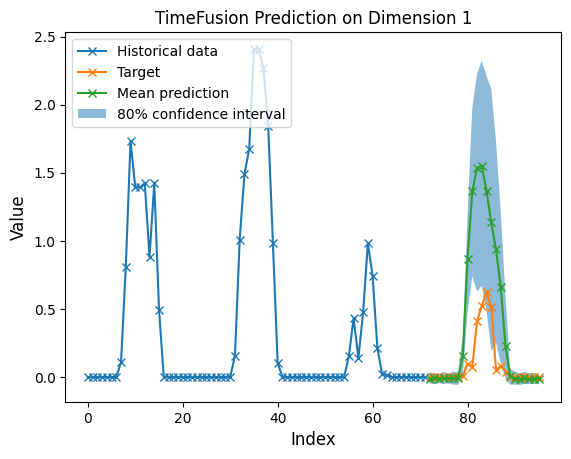

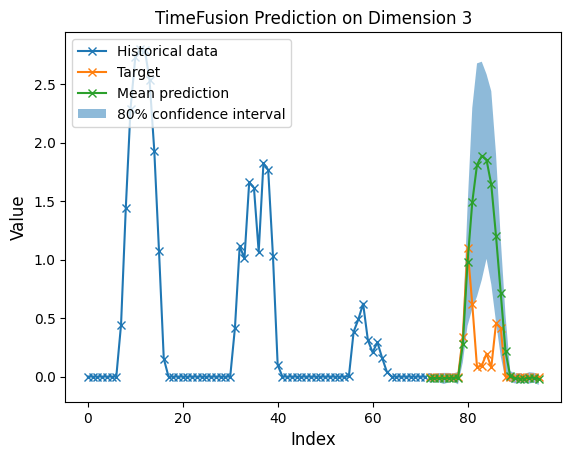

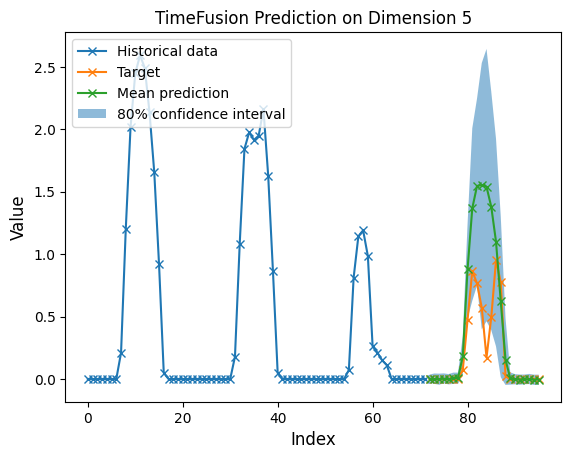

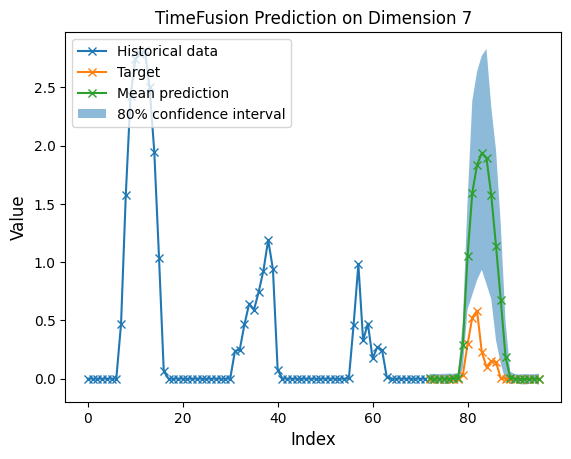

In [16]:
# Sample from model
last_idx = test_dataset.tensor_data.shape[0] - prediction_length - context_length
indices = [last_idx]
max_anchors = []
min_anchors = []
for idx in indices:
    off_idx = idx + context_length
    max_values = full_data.loc[full_data.index < test_data.index[off_idx]].max(axis=0)
    min_values = full_data.loc[full_data.index < test_data.index[off_idx]].min(axis=0)
    mean_values = full_data.loc[full_data.index < test_data.index[off_idx]].mean(axis=0)
    max_anchors.append(1.1*torch.tensor(max_values,dtype=torch.float32,device=device) - 0.1*torch.tensor(mean_values,dtype=torch.float32,device=device))
    min_anchors.append(1.1*torch.tensor(min_values,dtype=torch.float32,device=device) - 0.1*torch.tensor(mean_values,dtype=torch.float32,device=device))

max_anchors = torch.stack(max_anchors)
min_anchors = torch.stack(min_anchors)
anchors = torch.stack([min_anchors,max_anchors],dim = -1).unsqueeze(2).repeat((1,1,prediction_length,1))

samples = predictor.sample(
    data = test_dataset,
    indices = indices,
    prediction_length = prediction_length,
    num_samples = 128,
    anchors=anchors,
    anchor_strength=0.03,
)
samples = samples.cpu()

# Sort samples in ascending order
samples = samples.permute(0,2,3,1).flatten(start_dim=0,end_dim=2).sort()[0].reshape(samples.shape[0],samples.shape[2],samples.shape[3],-1).permute(0,3,1,2)

# Plot some predictions
confidence = 0.9

for ts in [1,3,5,7]:
    plt.figure()
    plt.title(f"TimeFusion Prediction on Dimension {ts}")
    plt.plot(test_dataset.tensor_data[indices[0] - (3*prediction_length - context_length):indices[0] + context_length,ts],"-x")
    plt.plot(list(range(3*prediction_length,4*prediction_length)),test_dataset.tensor_data[indices[0] + context_length:indices[0] + context_length+prediction_length,ts],"-x")
    plt.plot(list(range(3*prediction_length,4*prediction_length)),torch.mean(samples[0,:,ts],dim = 0),"-x")
    plt.fill_between(list(range(3*prediction_length,4*prediction_length)), samples[0,int(confidence*samples.shape[1]),ts], samples[0,int((1-confidence)*samples.shape[1]),ts],alpha=0.5)
    plt.legend(["Historical data","Target","Mean prediction","80% confidence interval"],loc='upper left')
    plt.xlabel("Index",fontsize=12)
    plt.ylabel("Value",fontsize=12)
    plt.savefig(f"images/solar_{ts}.png")


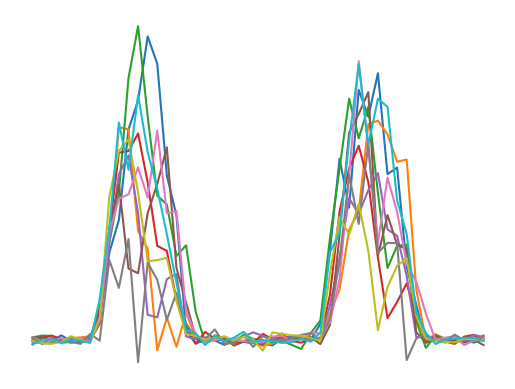

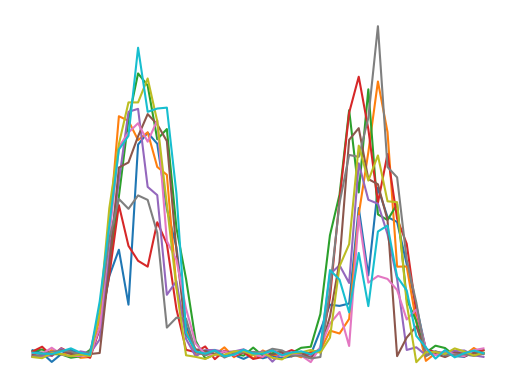

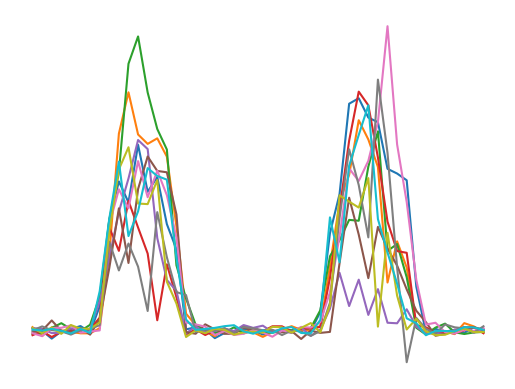

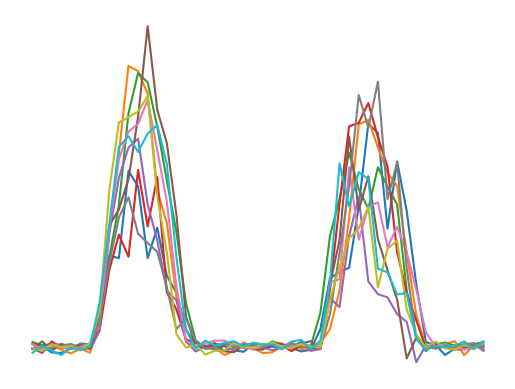

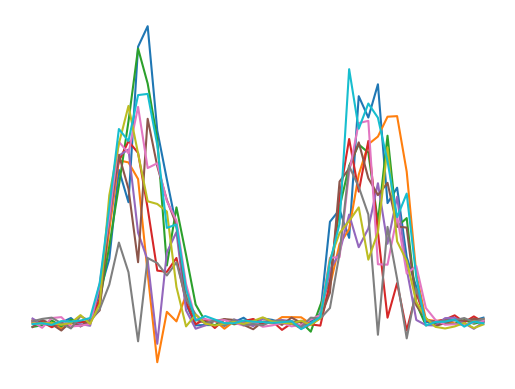

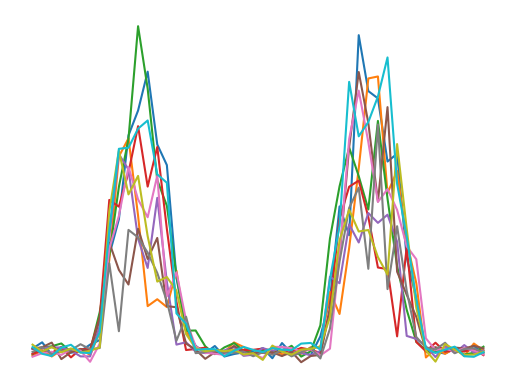

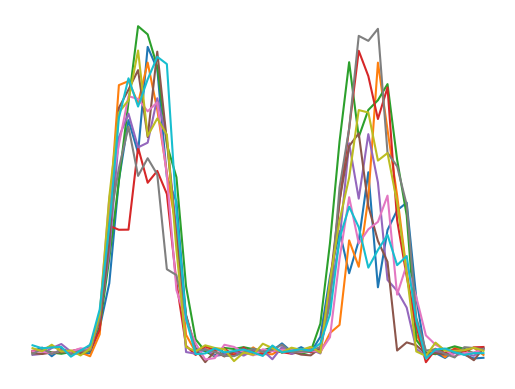

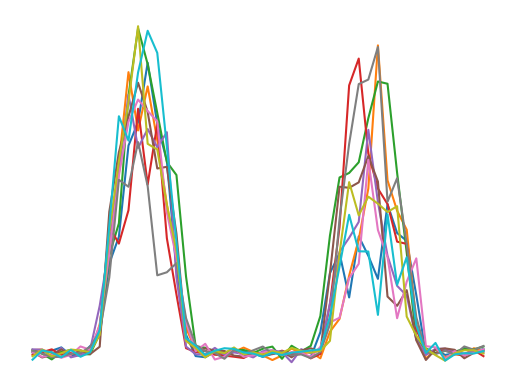

In [31]:
# Sample from model
last_idx = test_dataset.tensor_data.shape[0] - prediction_length - context_length
indices = [last_idx-24*3]
max_anchors = []
min_anchors = []
for idx in indices:
    off_idx = idx + context_length
    max_values = full_data.loc[full_data.index < test_data.index[off_idx]].max(axis=0)
    min_values = full_data.loc[full_data.index < test_data.index[off_idx]].min(axis=0)
    mean_values = full_data.loc[full_data.index < test_data.index[off_idx]].mean(axis=0)
    max_anchors.append(1.1*torch.tensor(max_values,dtype=torch.float32,device=device) - 0.1*torch.tensor(mean_values,dtype=torch.float32,device=device))
    min_anchors.append(1.1*torch.tensor(min_values,dtype=torch.float32,device=device) - 0.1*torch.tensor(mean_values,dtype=torch.float32,device=device))

max_anchors = torch.stack(max_anchors)
min_anchors = torch.stack(min_anchors)
anchors = torch.stack([min_anchors,max_anchors],dim = -1).unsqueeze(2).repeat((1,1,2*prediction_length,1))

samples = predictor.sample(
    data = test_dataset,
    indices = indices,
    prediction_length = 2*prediction_length,
    num_samples = 128,
    anchors=anchors,
    anchor_strength=0.05,
)
samples = samples.cpu()


for ts in [1,3,5,7,9,11,13,15]:
    plt.figure()
    for i in range(10):
        plt.plot(samples[0,i,ts],"-")
    plt.axis('off')
    plt.savefig(f"images/front_{ts}.png",dpi=1000)
